In [1]:
import os
import sys

sys.path.append("../")

In [ ]:
import torch
from deeplab import network
from datasets import load_dataset

MODEL_NAME = "deeplabv3plus_mobilenet"
MODEL_PATH = f"{os.environ['HOME']}/Downloads/deeplab_v3_plus_mobilenet.pth"

# Create the model
model = network.__dict__[MODEL_NAME](num_classes=19)
model.load_state_dict(torch.load(MODEL_PATH)['model_state'])
model.cuda()
model.eval()
# Load the dataset
dataset = load_dataset("ntudlcv/dlcv_2024_final1")

In [6]:
from deeplab.datasets import Cityscapes
from torchvision import transforms as T

transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

decode_fn = Cityscapes.decode_target

In [7]:
from torch.utils.data import DataLoader
from PIL import Image


# Custom collate function to handle dictionaries with PIL images
def collate_fn(batch):
    images = [item["image"] for item in batch]
    other_properties = [
        {k: v for k, v in item.items() if k != "image"} for item in batch
    ]
    return images, other_properties


# Create a DataLoader for the dataset with the custom collate function
data_loader = DataLoader(
    dataset["train"], batch_size=8, shuffle=True, collate_fn=collate_fn
)

# Load only one batch
images, other_properties = next(iter(data_loader))

# Get depth maps for the images
masks = []
for image in images:
    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        image = transform(image).unsqueeze(0).cuda()
        output = model(image)
        pred = output.max(1)[1].cpu().numpy()[0]
        colorized_preds = decode_fn(pred).astype('uint8')
        colorized_preds = Image.fromarray(colorized_preds)
        masks.append(colorized_preds)

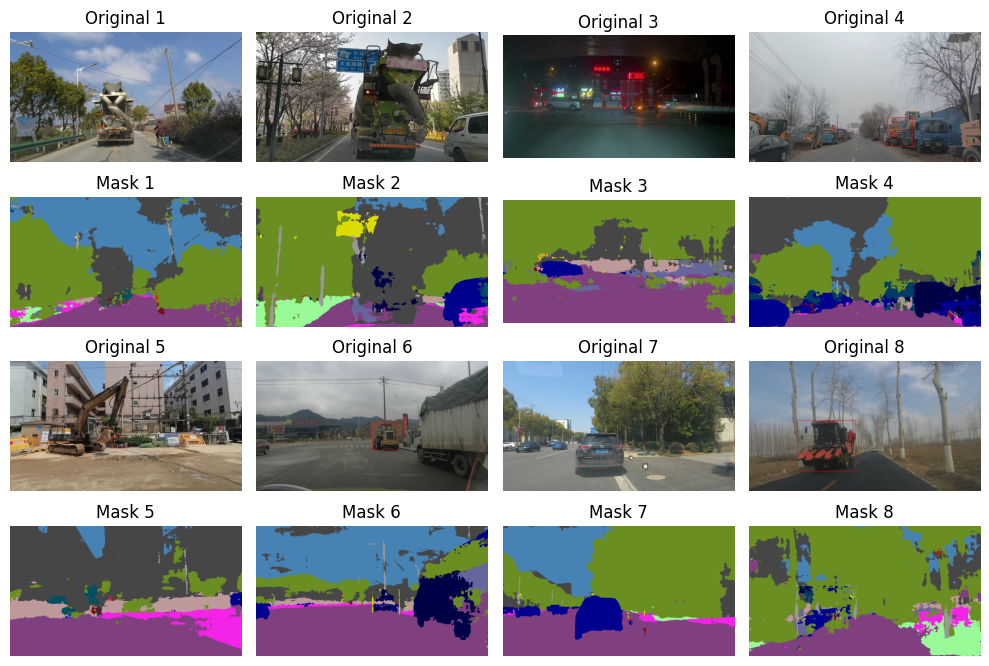

In [8]:
import matplotlib.pyplot as plt

# Plot a grid showing the original images and the depth maps
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 7))

for i, (image, mask) in enumerate(zip(images, masks)):
    row = (i // 4) * 2
    col = i % 4

    axes[row, col].imshow(image)
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Original {i+1}")

    axes[row + 1, col].imshow(mask)
    axes[row + 1, col].axis("off")
    axes[row + 1, col].set_title(f"Mask {i+1}")

plt.tight_layout(h_pad=0)
plt.show()